In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel


import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [13]:
df = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240119-3.csv')
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')

In [14]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Remove specified columns
columns_to_remove = ['Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_remove)

# Merge with venue information
df = pd.merge(df, df_venue[['EVSE ID', 'Charging Venue', 'Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude (y)', 'Longitude (x)']], on='EVSE ID', how='left')

# ZIP code distance  Zip/Postal Code    and   Driver Zip/Postal Code

# Initialize the Search Engine
search = SearchEngine()

# Initialize pandarallel
pandarallel.initialize()


zip_dict = {}

def get_lat_long(zip_code):
    if pd.isna(zip_code):
        return (None, None)
    if zip_code not in zip_dict:
        result = search.by_zipcode(zip_code)
        if result:
            zip_dict[zip_code] = (result.lat, result.lng)
        else:
            zip_dict[zip_code] = (None, None)  # Default value
    return zip_dict[zip_code]



def calculate_distance(row):
    try:
        # Get the lat, long for both zip codes
        loc1 = get_lat_long(row['Zip/Postal Code'])
        loc2 = get_lat_long(row['Driver Zip/Postal Code'])

        # If either location is None, return None
        if None in loc1 or None in loc2:
            return None


        return geodesic(loc1, loc2).miles
    except Exception as e:
        print(f"Error: {e}")
        return None


# Apply the function 
df['zip_dis'] = df.parallel_apply(calculate_distance, axis=1)
df['zip_dis'].fillna(df['zip_dis'].median(), inplace=True)


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_8468\3535929862.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['zip_dis'].fillna(df['zip_dis'].median(), inplace=True)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_8468\3535929862.py:54: FutureWarning: Downcasting object dtype a

In [15]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])
#df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
#df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]




# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)

# Add VENUE features


#df['ven_hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)
df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Medical') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_muni'] = (df['Charging Venue'] == 'Citty Hall').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Retail').astype(int)
#df['ven_transit'] = (df['Charging Venue'] == 'Transit').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()


#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']

#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------

####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
df_TN=df[df['State/Province']=='Tennessee']

In [5]:
df_DC['Fee'].sum()

137033.58000000002

In [6]:
df

,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),...,ven_parking,ven_retail,previous_end_time,idle,idle_hour,idle_day,SOC_diff,Service_Days,Event Count,Normalized Event Count
0,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 09:49:44,EST,2018-11-06 12:42:42,EST,2018-11-06 09:42:43,02:53:01,02:52:48,18.434,...,0,0,NaT,NaT,NaN,NaN,0,1900,1709,0.899474
1,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 13:00:11,EST,2018-11-06 14:55:52,EST,2018-11-06 11:55:53,01:55:44,01:55:34,12.150,...,0,0,NaT,NaT,NaN,NaN,0,1900,1709,0.899474
2,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-09 20:09:21,EST,2018-11-10 00:00:20,EST,2018-11-09 21:01:04,03:51:03,03:50:48,24.547,...,0,0,2018-11-06 14:55:52,3 days 05:13:29,77.224722,3.217697,0,1900,1709,0.899474
3,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-15 09:00:57,EST,2018-11-15 16:18:57,EST,2018-11-15 13:19:39,07:17:58,03:12:38,11.089,...,0,0,2018-11-10 00:00:20,5 days 09:00:37,129.010278,5.375428,0,1900,1709,0.899474
4,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-16 08:48:16,EST,2018-11-16 14:35:43,EST,2018-11-16 11:36:25,05:47:27,03:24:12,11.365,...,0,0,2018-11-15 16:18:57,0 days 16:29:19,16.488611,0.687025,0,1900,1709,0.899474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32179,0024:B100:0008:1FA0,Smithville Electric System,2023-12-23 08:39:04,CST,2023-12-23 09:33:13,CST,2023-12-23 07:33:16,00:54:08,00:31:58,29.475,...,1,0,2023-12-15 17:03:36,7 days 15:35:28,183.591111,7.649630,32,17,5,0.294118
32180,0024:B100:0008:1FA0,Smithville Electric System,2023-12-25 21:54:09,CST,2023-12-25 22:16:58,CST,2023-12-25 20:17:01,00:22:49,00:22:08,27.751,...,1,0,2023-12-23 09:33:13,2 days 12:20:56,60.348889,2.514537,17,17,5,0.294118
32181,0024:B100:0008:1FA0,Smithville Electric System,2023-12-30 15:58:05,CST,2023-12-30 16:43:00,CST,2023-12-30 14:43:03,00:44:54,00:44:14,52.354,...,1,0,2023-12-25 22:16:58,4 days 17:41:07,113.685278,4.736887,65,17,5,0.294118
32182,0024:B100:0008:1FA0,Smithville Electric System,2024-01-01 17:05:20,CST,2024-01-01 17:19:01,CST,2024-01-01 15:19:08,00:13:41,00:13:29,11.990,...,1,0,2023-12-30 16:43:00,2 days 00:22:20,48.372222,2.015509,15,17,5,0.294118


#   **Daily Usage**

In [5]:
#Station utilization: The average energy delivered by a station during a time period divided by the number of ports a

df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date
# 2023
#df_tennessee_2023 = df[(df['State/Province'] == 'Tennessee') & (df['Start_Time_EST'].dt.year == 2023)]
#df_tennessee_2023 = df[df['Start_Time_EST'].dt.year == 2023]


unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID
daily_events = df.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   average daily basis in kilowatt-hours per port per day
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')

# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)



merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

merged_df_GIS = df_GIS[['EVSE ID', 'Business_Dis', 'Business_Name', 'Business_Label', 'Grocery_Dis', 'Grocer_ Name', 'County_population_2021',
                         'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name', 'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 
                         'Hotel_Label', 'Parks_Dis', 'Parks_Name', 'Park_Label',
                         'Comprehensive_Dis', 'Comprehencive_Name', 'Comp_Label', 'Weight']].drop_duplicates()

utilization_station_data = pd.merge(utilization_station_data, merged_df_GIS, on='EVSE ID', how='left')

# Add EV for TN 
#tn_ev_county= df_tn_reg.groupby(['County'])['Vehicle Count'].sum().reset_index()
#utilization_station_data = pd.merge(utilization_station_data, tn_ev_county, on='County', how='left')
#utilization_station_data['percentage of poulation']=(utilization_station_data['Vehicle Count']*100)/utilization_station_data['County_population_2021']
#utilization_station_data.dropna(subset=['percentage of poulation'], inplace=True)



# Normalized Event count 
merged_df_normalized =  df[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports', 'Utilization Rate']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')



# Station utilization  (kWh/port/day)
# station utilization as the average energy delivered by a station during a time period divided by the number of ports.

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']


#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Medical' )).astype(int)
utilization_station_data['ven_muni'] = (utilization_station_data['Charging Venue'] == 'Citty Hall').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Retail').astype(int)
utilization_station_data['ven_transit'] = (utilization_station_data['Charging Venue'] == 'Transit').astype(int)

# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)

# demographic data 
search = SearchEngine()

def get_demographics(zip_code):
    result = search.by_zipcode(zip_code)
    return result.population, result.population_density, result.median_home_value, result.median_household_income

utilization_station_data['population'], utilization_station_data['population_density'], utilization_station_data['median_home_value'],  utilization_station_data['median_household_income'] =  zip(*utilization_station_data['Zip/Postal Code'].apply(get_demographics))
columns_to_convert_to_float = ['population', 'population_density', 'median_home_value']
utilization_station_data[columns_to_convert_to_float] = utilization_station_data[columns_to_convert_to_float].astype(float)

columns_with_inf = ['Normalized Event Count', 'Utilization Rate']
utilization_station_data[columns_with_inf] = utilization_station_data[columns_with_inf].replace([np.inf, -np.inf], np.nan)
utilization_station_data[columns_with_inf] = utilization_station_data[columns_with_inf].fillna(utilization_station_data[columns_with_inf].mean())



#Scaler
columns_to_scale = [ 'Fee', 'Normalized Event Count','Utilization Rate','median_household_income','population_density' ]
# Replace infinite values with NaN
utilization_station_data[columns_to_scale].replace([np.inf, -np.inf], np.nan, inplace=True)
 #Count NaN values in each column
inf_counts = utilization_station_data[columns_to_scale].isnull().sum()
print("Counts of infinite values:")
#print(inf_counts)

scaler = MinMaxScaler()
utilization_station_data[columns_to_scale] = scaler.fit_transform(utilization_station_data[columns_to_scale])


# DF for L2 and DC 
#df_station_daily_L2 = utilization_station_data[utilization_station_data['Port Type'].str.fullmatch('Level 2')]
df_station_daily_DC = utilization_station_data[utilization_station_data['Port Type'].str.fullmatch('DC Fast')]

Counts of infinite values:


C:\Users\mehdi\AppData\Local\Temp\ipykernel_28324\4095932826.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utilization_station_data[columns_to_scale].replace([np.inf, -np.inf], np.nan, inplace=True)


187566.72

In [8]:
df_station_daily_DC

,EVSE ID,Port Number,Date,Energy (kWh),Number of Events,Charging Time,Fee,Day_of_Week,Is_Weekday,Is_Weekend,...,ven_retail,ven_transit,DC,L2,cost_free,cost_paid,population,population_density,median_home_value,median_household_income
6606,2118081,2,2020-07-15,26.996,1,1.450000,0.000000,2,1,0,...,0,0,1,0,1,0,36687.0,0.115556,139100.0,0.396218
6607,2118081,2,2020-07-16,15.871,1,0.333333,0.000000,3,1,0,...,0,0,1,0,1,0,36687.0,0.115556,139100.0,0.396218
6608,2118081,2,2020-07-22,46.978,5,1.450000,0.000000,2,1,0,...,0,0,1,0,1,0,36687.0,0.115556,139100.0,0.396218
6609,2118081,2,2020-07-29,25.934,1,0.516667,0.050421,2,1,0,...,0,0,1,0,0,1,36687.0,0.115556,139100.0,0.396218
6610,2118081,2,2020-08-07,29.157,3,0.874444,0.084009,4,1,0,...,0,0,1,0,0,1,36687.0,0.115556,139100.0,0.396218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21271,15250771,1,2023-12-15,24.888,1,0.364722,0.081437,4,1,0,...,0,0,1,0,0,1,13446.0,0.019259,116500.0,0.556508
21272,15250771,1,2023-12-23,29.475,1,0.532778,0.096478,5,0,1,...,0,0,1,0,0,1,13446.0,0.019259,116500.0,0.556508
21273,15250771,1,2023-12-25,27.751,1,0.368889,0.090867,0,1,0,...,0,0,1,0,0,1,13446.0,0.019259,116500.0,0.556508
21274,15250771,1,2023-12-30,52.354,1,0.737222,0.171368,5,0,1,...,0,0,1,0,0,1,13446.0,0.019259,116500.0,0.556508


# **venue utilization**

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


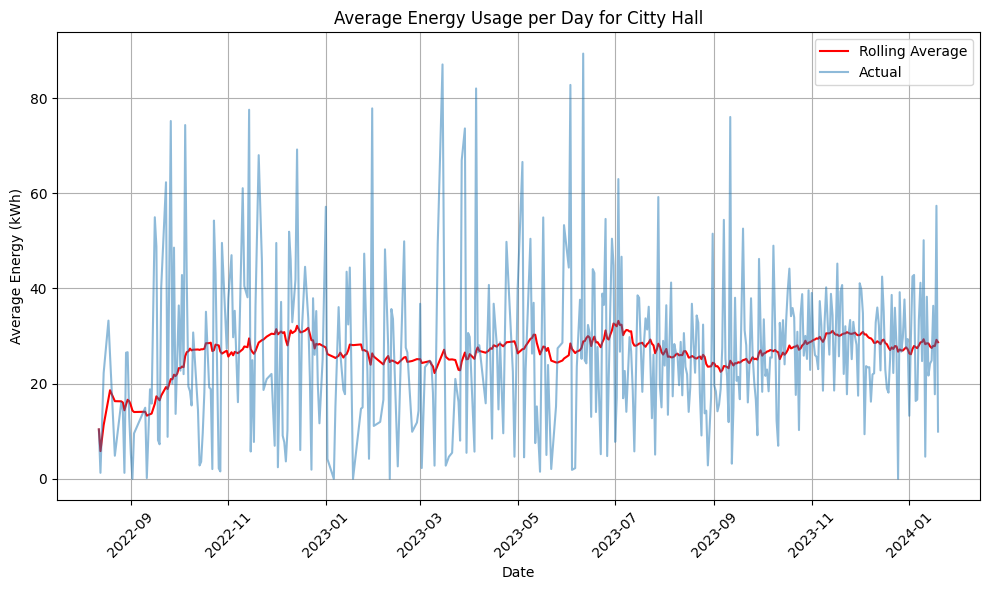

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


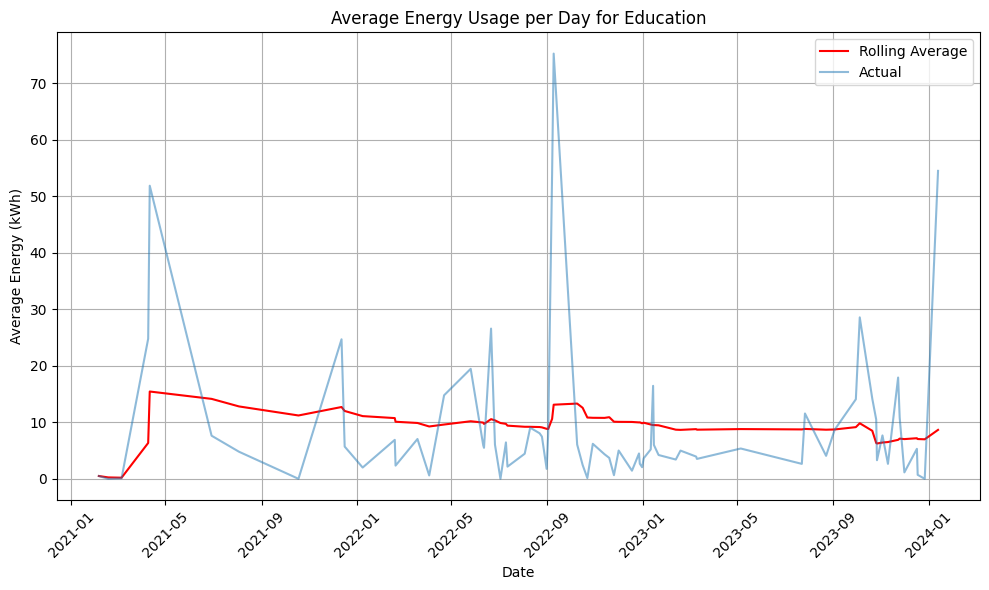

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


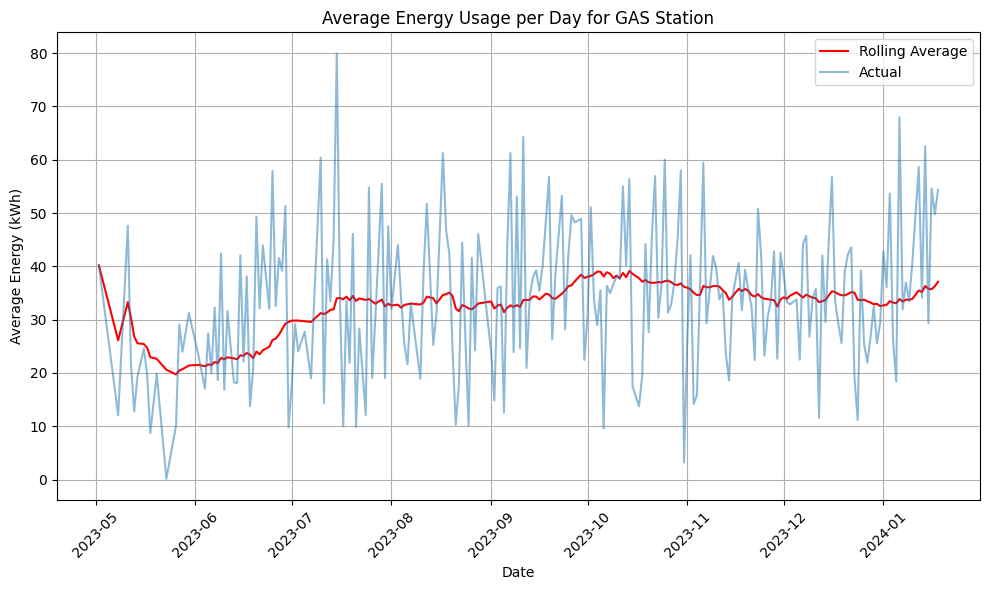

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


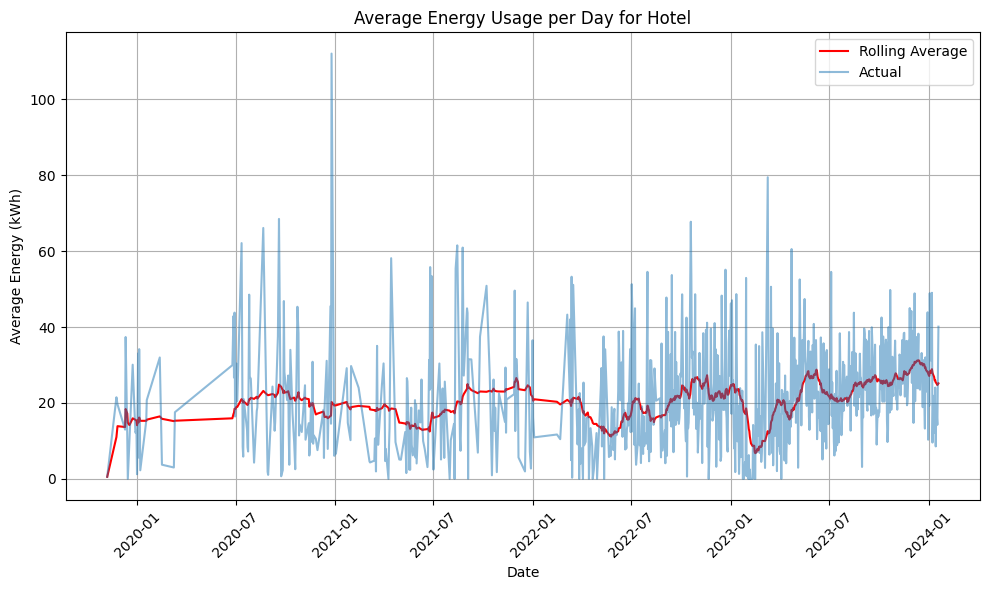

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


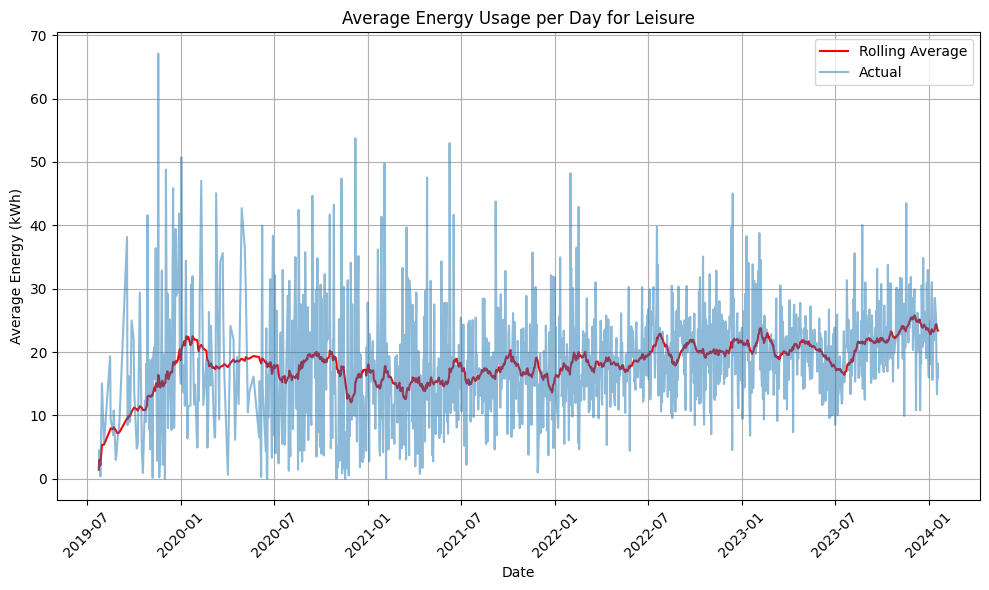

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


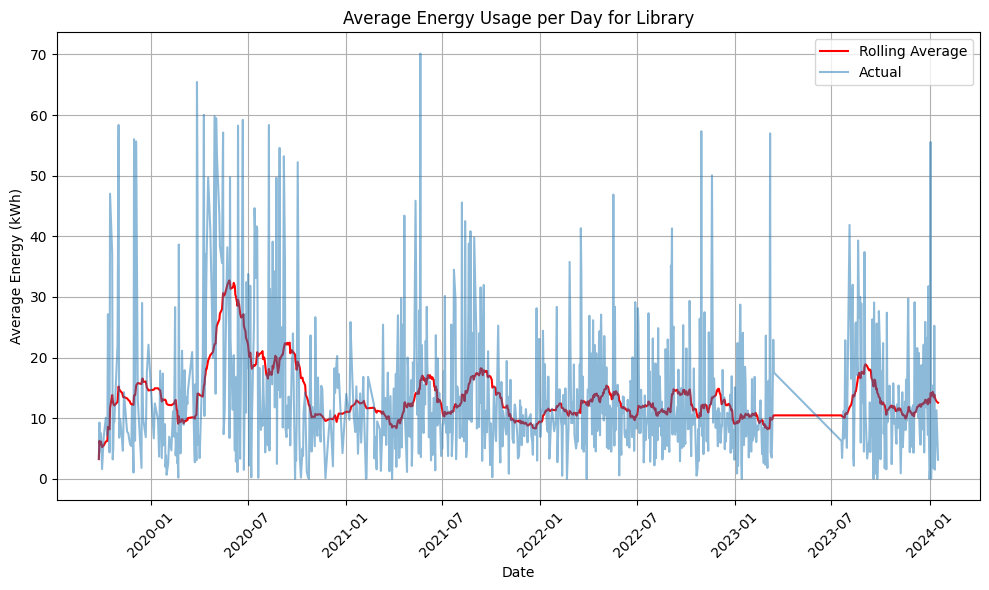

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


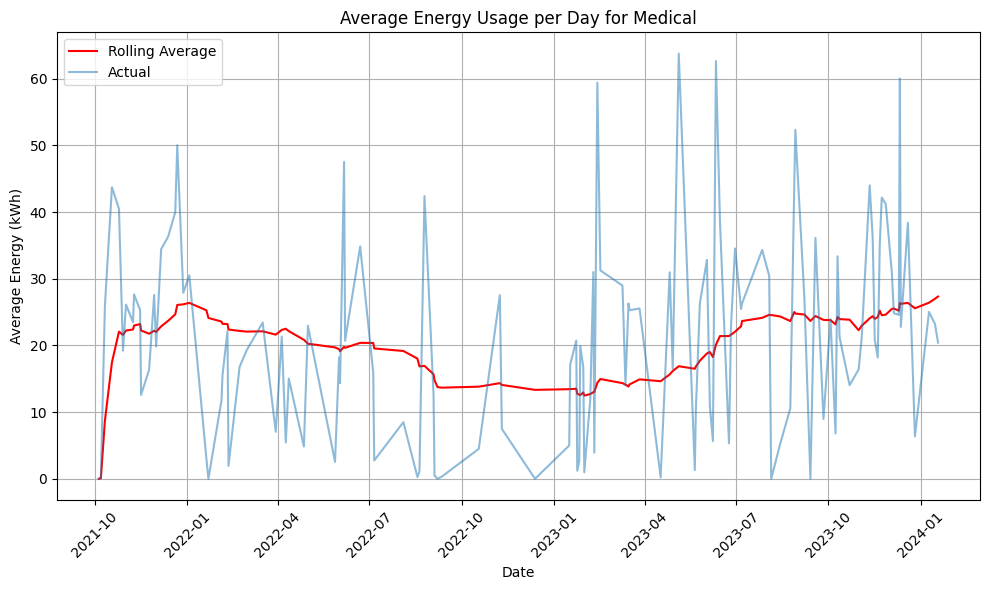

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


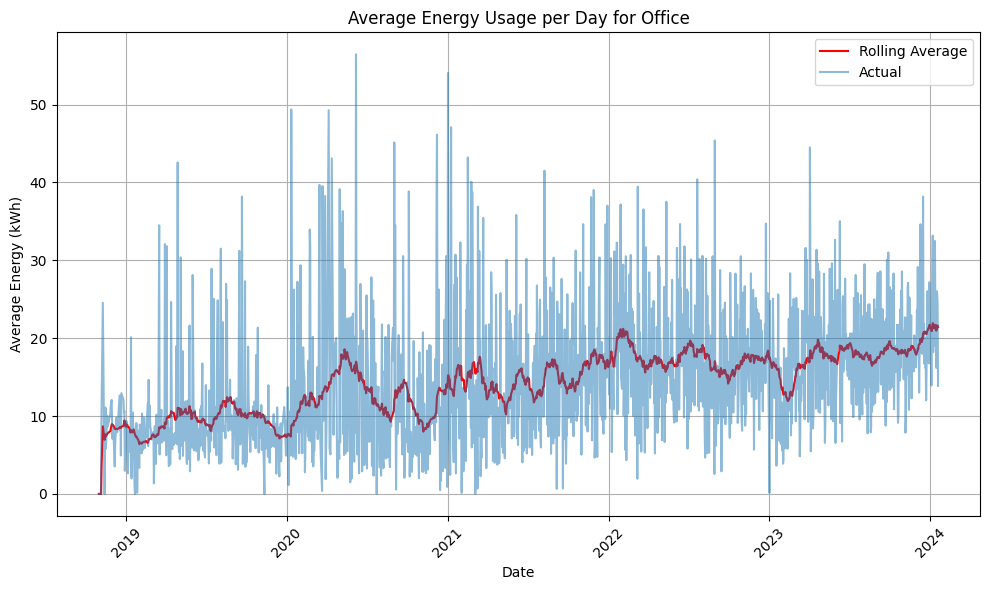

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


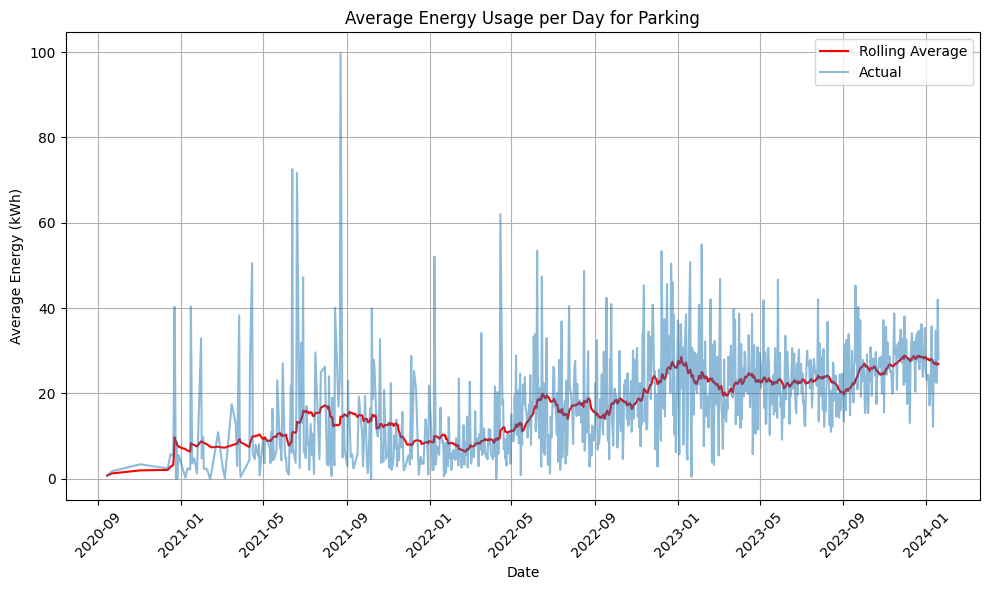

C:\Users\mehdi\AppData\Local\Temp\ipykernel_27540\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


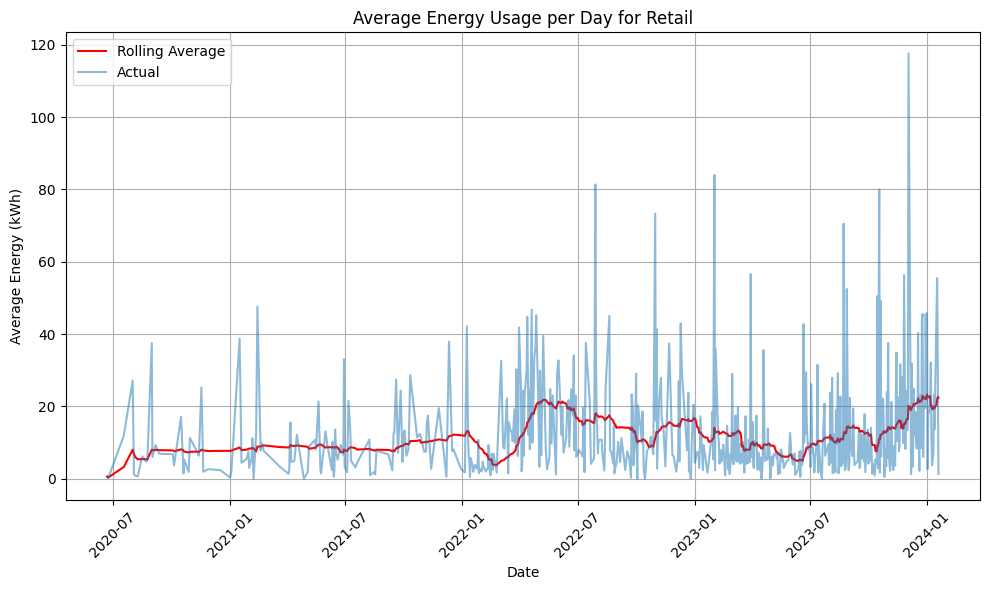

In [36]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

df['Date'] = df['Start_Time_EST'].dt.date

# Group by venue and date, and calculate average energy per day for each venue
venue_utilization_data = df.groupby(['Charging Venue', 'Date'])['Energy (kWh)'].mean().reset_index()

# Plot for each venue with a rolling average
venues = venue_utilization_data['Charging Venue'].unique()

for venue in venues:
    plt.figure(figsize=(10, 6))
    venue_data = venue_utilization_data[venue_utilization_data['Charging Venue'] == venue]

    # Calculate a 30-day rolling average for smoother trend
    venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()

    plt.plot(venue_data['Date'], venue_data['Rolling Average'], label='Rolling Average', color='red')
    plt.plot(venue_data['Date'], venue_data['Energy (kWh)'], label='Actual', alpha=0.5)

    plt.title(f'Average Energy Usage per Day for {venue}')
    plt.xlabel('Date')
    plt.ylabel('Average Energy (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:


# Create a map centered around the mean latitude and longitude
center_lat = df_GIS['Latitude'].mean()
center_lon = df_GIS['Longitude'].mean()
map_evse = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add markers for each EVSE location with marker size based on the 'Weight' column
for index, row in df_GIS.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Weight'],
        popup=row['Station Name'],
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_evse)

# Display the map
#map_evse


# Perform OLS regression DC only 

RF, DT 
Using PCA
Regulization
Other features to model


In [8]:

independent_vars = ['Fee', 'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 
                    'Business_Label', 'HWY_Label', 'Hotel_Label', 'Weight', 
                    'Normalized Event Count', 'ven_leisure', 'ven_med_ed', 
                    'ven_muni', 'ven_office', 'ven_parking', 'ven_retail', 
                    'cost_free', 'cost_paid', 'Utilization Rate',
                    'median_household_income','population_density']

X = df_station_daily_DC[independent_vars]
Y = df_station_daily_DC['Util_station (kWh/port/day)']

# Check for infinity and NaN
is_infinite = np.isinf(X).any()
print("Infinite values in independent variables:")
print(is_infinite)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))


X.reset_index(drop=True, inplace=True)
Y = Y.iloc[X.index]
Y.reset_index(drop=True, inplace=True)

Infinite values in independent variables:
Fee                        False
Day_of_Week                False
Is_Weekday                 False
Is_Weekend                 False
Business_Label             False
HWY_Label                  False
Hotel_Label                False
Weight                     False
Normalized Event Count     False
ven_leisure                False
ven_med_ed                 False
ven_muni                   False
ven_office                 False
ven_parking                False
ven_retail                 False
cost_free                  False
cost_paid                  False
Utilization Rate           False
median_household_income    False
population_density         False
dtype: bool
Number of samples in X: 7570
Number of samples in Y: 7570


In [9]:
# Double-check lengths of X and Y
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))

# Verify index ranges
print("Index range of X:", X.index.min(), "-", X.index.max())
print("Index range of Y:", Y.index.min(), "-", Y.index.max())

# Check if X's indices are within the range of Y's indices
if X.index.max() > Y.index.max() or X.index.min() < Y.index.min():
    print("Indices of X are out of range for Y")

# Check if Y's indices are within the range of X's indices
if Y.index.max() > X.index.max() or Y.index.min() < X.index.min():
    print("Indices of Y are out of range for X")


Number of samples in X: 7570
Number of samples in Y: 7570
Index range of X: 0 - 7569
Index range of Y: 0 - 7569


In [10]:
# K-Fold cross-validation
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X, Y, cv=5)
print("Cross-validation scores (Linear Regression): ", scores)
print("Average cross-validation score (Linear Regression): ", np.mean(scores))

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Testing set:", X_test.shape, Y_test.shape)

# Fit the OLS regression model on the training data
model_ols = sm.OLS(Y_train, X_train).fit()
print(model_ols.summary())

# Calculate the validation score (R-squared)
Y_val_pred = model_ols.predict(X_val)
val_score = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (OLS): ", val_score)

# Calculate the test score (R-squared)
Y_test_pred = model_ols.predict(X_test)
test_score = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (OLS): ", test_score)

Cross-validation scores (Linear Regression):  [0.78095317 0.73391527 0.66945447 0.71363967 0.91514453]
Average cross-validation score (Linear Regression):  0.7626214213217132
Training set: (5299, 20) (5299,)
Validation set: (1135, 20) (1135,)
Testing set: (1136, 20) (1136,)
                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.897
Model:                                     OLS   Adj. R-squared:                  0.897
Method:                          Least Squares   F-statistic:                     2712.
Date:                         Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                                 23:08:00   Log-Likelihood:                -17424.
No. Observations:                         5299   AIC:                         3.488e+04
Df Residuals:                             5281   BIC:                         3.500e+04
Df Model:            

In [11]:
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.897
Model:                                     OLS   Adj. R-squared:                  0.897
Method:                          Least Squares   F-statistic:                     2712.
Date:                         Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                                 23:09:25   Log-Likelihood:                -17424.
No. Observations:                         5299   AIC:                         3.488e+04
Df Residuals:                             5281   BIC:                         3.500e+04
Df Model:                                   17                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [12]:
X1 = sm.add_constant(X)
vif = pd.DataFrame()
vif["variables"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
print(vif)

                  variables        VIF
0                     const   0.000000
1                       Fee   1.145488
2               Day_of_Week   2.662586
3                Is_Weekday        inf
4                Is_Weekend        inf
5            Business_Label   9.280024
6                 HWY_Label   5.464967
7               Hotel_Label   3.544976
8                    Weight  15.891906
9    Normalized Event Count  30.671725
10              ven_leisure   6.473814
11               ven_med_ed        NaN
12                 ven_muni   3.498432
13               ven_office   2.490198
14              ven_parking   4.037783
15               ven_retail   1.269791
16                cost_free        inf
17                cost_paid        inf
18         Utilization Rate  35.980593
19  median_household_income   5.582482
20       population_density   7.552360


c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


# DT

In [14]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the decision tree regressor
model_DT = DecisionTreeRegressor(random_state=42)

# Train the model
model_DT.fit(X_train, Y_train)

# Make predictions
Y_pred = model_DT.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 3.038239982386614
Mean Squared Error: 66.15209771372743
R-squared: 0.8257610955789443


# RF Hyperparameters

High multicollinearity can be a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret.
You might want to consider dropping or transforming some of these variables to address the multicollinearity issue. For example, you could use Principal Component Analysis (PCA) to reduce the dimensionality of your dataset, or you could remove some of the highly correlated variables. You could also consider using regularization techniques like Ridge or Lasso regression which can help in handling multicollinearity.


Correlations with the dependent variable:
Fee                            0.927910
Day_of_Week                    0.090712
Is_Weekday                    -0.081820
Is_Weekend                     0.081820
Business_Label                 0.044532
HWY_Label                     -0.188314
Hotel_Label                    0.181737
Weight                        -0.057356
Normalized Event Count         0.288127
ven_leisure                   -0.008139
ven_med_ed                          NaN
ven_muni                       0.059490
ven_office                    -0.111201
ven_parking                   -0.014526
ven_retail                    -0.011666
cost_free                     -0.036982
cost_paid                      0.036982
Utilization Rate               0.278783
median_household_income        0.062034
population_density            -0.070585
Util_station (kWh/port/day)    1.000000
Name: Util_station (kWh/port/day), dtype: float64
Validation R^2 score (Random Forest): 0.8651590239533291
Test R^2 s

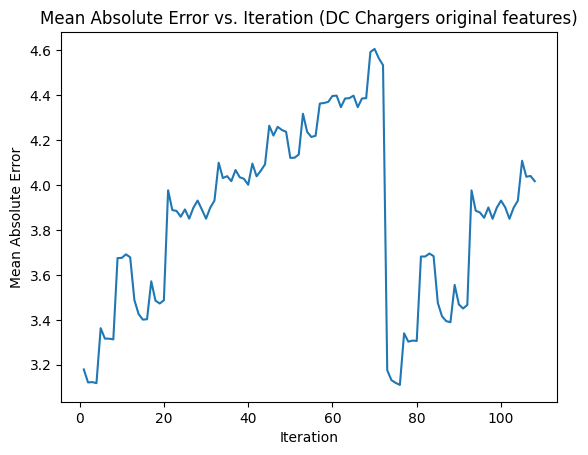


Mean MAE: 3.8529 (+/- 0.3949)
Mean R^2: 0.8558 (+/- 0.0069)
Test MAE: 3.3164
Test R^2: 0.8845


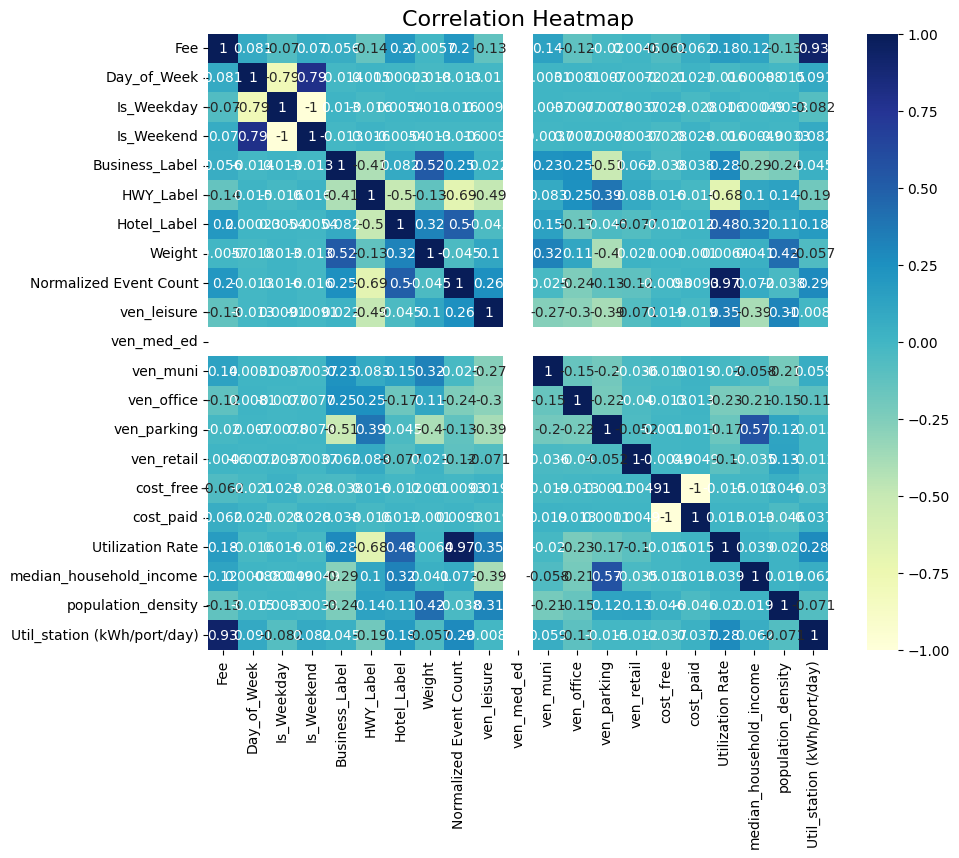

In [18]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Calculate the Pearson correlation coefficients
corr_matrix = X.join(Y).corr()
corr_with_target = corr_matrix[Y.name]

# Print the correlation coefficients with the dependent variable
print("\nCorrelations with the dependent variable:")
print(corr_with_target)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_val_pred = rf_model.predict(X_val)
val_score_rf = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (Random Forest):", val_score_rf)

Y_test_pred = rf_model.predict(X_test)
test_score_rf = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (Random Forest):", test_score_rf)




param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



mae_values = []
train_scores = []
test_scores = []
r2_scores = []  # Initialize r2_scores list

# Perform cross-validation to get MAE, training, and testing scores after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train, Y_train)

        # Calculate MAE
        Y_pred = rf.predict(X_test)
        mae = mean_absolute_error(Y_test, Y_pred)
        mae_values.append(mae)

        # Calculate R-squared scores for training and testing sets
        train_score = rf.score(X_train, Y_train)
        test_score = rf.score(X_test, Y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

        # Calculate R-squared score for validation set
        r2_score_val = r2_score(Y_val, rf.predict(X_val))
        r2_scores.append(r2_score_val)

        print(f"Iteration {i+1}: MAE = {mae}, Train Score = {train_score}, Test Score = {test_score}, Val Score = {r2_score_val}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")


# Plot MAE values
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration (DC Chargers original features)')
plt.show()

from sklearn.metrics import r2_score
# Calculate the mean and standard deviation of MAE and R^2
mae_mean = np.mean(mae_values)
mae_std = np.std(mae_values)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
print(f"\nMean MAE: {mae_mean:.4f} (+/- {mae_std:.4f})")
print(f"Mean R^2: {r2_mean:.4f} (+/- {r2_std:.4f})")

# Make predictions on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}") 
print(f"Test R^2: {test_r2:.4f}")

# Create a heatmap visualization for correlation 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Correlations with the dependent variable:
Fee                        0.927910
Day_of_Week                0.090712
Is_Weekday                -0.081820
Is_Weekend                 0.081820
Business_Label             0.044532
HWY_Label                 -0.188314
Hotel_Label                0.181737
Weight                    -0.057356
Normalized Event Count     0.288127
ven_leisure               -0.008139
ven_med_ed                      NaN
ven_muni                   0.059490
ven_office                -0.111201
ven_parking               -0.014526
ven_retail                -0.011666
cost_free                 -0.036982
cost_paid                  0.036982
Utilization Rate           0.278783
median_household_income    0.062034
population_density        -0.070585
Name: Util_station (kWh/port/day), dtype: float64
Pearson correlation coefficient: 0.9279104515028171


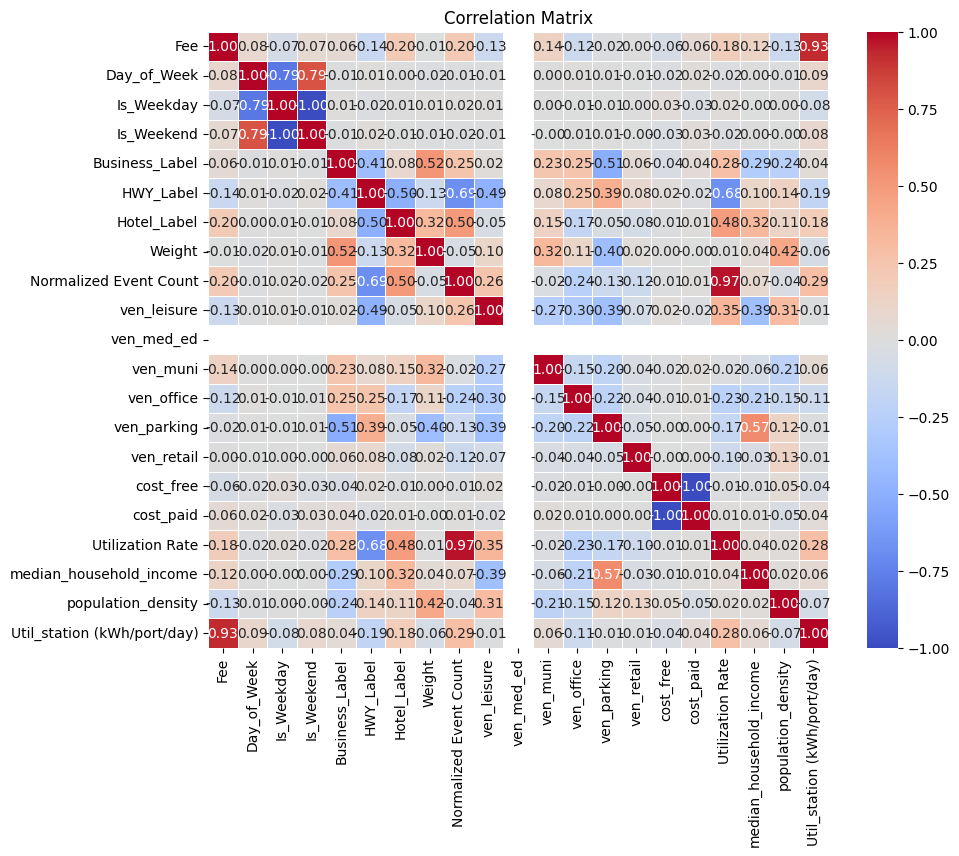

In [17]:
# Combine independent variables and dependent variable into one DataFrame
df_combined = pd.concat([X, Y], axis=1)

# Calculate correlations
correlations = df_combined.corr()

# Extract correlation values with the dependent variable
corr_with_dependent = correlations.iloc[:-1, -1]

# Print correlations with the dependent variable
print("Correlations with the dependent variable:")
print(corr_with_dependent)

# Calculate Pearson correlation coefficient
pearson_coefficient = df_combined.corr().iloc[:-1, -1].values[0]

print("Pearson correlation coefficient:", pearson_coefficient)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
correlations = df_combined.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()